In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import geopandas as gpd
from shapely.geometry import Point

# =============================
# 1. DataFrame Awal
# =============================

data = {
    "Bulan": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 
              1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 
              1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 
              1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    
    "Suhu (C)": [
        29.0, 28.9, 29.2, 29.1, 28.5, 28.3, 27.5, 27.2, 28.0, 28.6, 28.7, 28.4,
        28.2, 28.6, 28.5, 28.3, 27.9, 27.6, 26.7, 25.7, 27.3, 28.1, 28.1, 27.8,
        27.4, 27.6, 27.5, 27.7, 27.2, 27.0, 26.3, 25.8, 26.9, 27.3, 27.4, 27.1,
        26.5, 26.4, 26.6, 26.3, 25.9, 25.7, 25.0, 24.8, 25.5, 25.9, 26.1, 25.7
    ],
    
    "Kelembaban (%)": [
        85, 84, 83, 82, 81, 83, 84, 85, 86, 84, 83, 85,
        82, 83, 84, 83, 82, 82, 81, 80, 82, 81, 83, 84,
        80, 79, 78, 77, 79, 80, 81, 82, 81, 80, 79, 78,
        88, 87, 89, 88, 86, 85, 86, 87, 88, 89, 87, 86
    ],
    
    "Curah Hujan (mm)": [
        500, 180, 250, 300, 100, 70, 50, 15, 75, 130, 690, 540,
        450, 160, 210, 320, 90, 60, 40, 10, 85, 140, 700, 530,
        400, 120, 220, 280, 60, 45, 35, 5, 95, 145, 720, 510,
        550, 170, 230, 310, 95, 65, 45, 20, 70, 125, 680, 560
    ],
    
    "Jumlah Kasus DBD": [8, 5, 2, 10, 24, 5, 10, 9, 5, 1, 6, 1,
                         9, 7, 6, 10, 17, 11, 23, 13, 5, 5, 8, 12,
                         10, 14, 17, 12, 30, 19, 14, 12, 4, 2, 8, 11,
                         5, 4, 7, 10, 13, 16, 2, 7, 4, 3, 5, 11]
}

df = pd.DataFrame(data)

# =============================
# 2. Tambah Kecamatan & Koordinat
# =============================

kecamatan_list = ['Purwokerto Timur']*12 + ['Purwokerto Barat']*12 + ['Purwokerto Selatan']*12 + ['Purwokerto Utara']*12
koordinat = {
    'Purwokerto Timur': (-7.424467, 109.244497),
    'Purwokerto Barat': (-7.423089, 109.217737),
    'Purwokerto Selatan': (-7.442619, 109.241523),
    'Purwokerto Utara': (-7.3989999, 109.2385498)
}

df['Kecamatan'] = kecamatan_list
df['Latitude'] = df['Kecamatan'].apply(lambda x: koordinat[x][0])
df['Longitude'] = df['Kecamatan'].apply(lambda x: koordinat[x][1])

# =============================
# 3. Buat Label Target Biner
# =============================

df['Kasus DBD (0=Tidak, 1=Ya)'] = (df['Jumlah Kasus DBD'] > 5).astype(int)

# =============================
# 4. Persiapan Data untuk SVM
# =============================

X = df[['Suhu (C)', 'Kelembaban (%)', 'Curah Hujan (mm)', 'Bulan']]
y = df['Kasus DBD (0=Tidak, 1=Ya)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardisasi
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

# =============================
# 5. SMOTE untuk seimbangkan kelas
# =============================

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# =============================
# 6. Pelatihan Model SVM
# =============================

svm_model = SVC(kernel='rbf', class_weight='balanced', random_state=42)
svm_model.fit(X_train_resampled, y_train_resampled)

# Prediksi seluruh data
df['Prediksi DBD'] = svm_model.predict(X_scaled)

# =============================
# 7. Evaluasi Model
# =============================

y_pred = svm_model.predict(X_test_scaled)
print("Akurasi Model: ", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# =============================
# 8. Kategorisasi Warna (Manual)
# =============================

agg_df = df.groupby('Kecamatan').agg({
    'Prediksi DBD': 'sum',
    'Latitude': 'first',
    'Longitude': 'first'
}).reset_index()

# Urutkan dan beri label manual
agg_df = agg_df.sort_values('Prediksi DBD').reset_index(drop=True)
kategori_label = ['Rendah', 'Sedang', 'Tinggi', 'Sangat Tinggi']
agg_df['Kategori'] = kategori_label[:len(agg_df)]


# Peta warna
warna_map = {
    'Rendah'        : 'GREEN',
    'Sedang'        : 'YELLOW',
    'Tinggi'        : 'ORANGE',
    'Sangat Tinggi' : 'RED'
}

agg_df['Warna'] = agg_df['Kategori'].map(warna_map)

# =============================
# 9. Simpan ke CSV dan GeoJSON
# =============================

agg_df.to_csv('prediksi_dbd_kecamatan.csv', index=False)

geometry = [Point(xy) for xy in zip(agg_df['Longitude'], agg_df['Latitude'])]
gdf = gpd.GeoDataFrame(agg_df, geometry=geometry)
gdf.set_crs(epsg=4326, inplace=True)
gdf.to_file('prediksi_dbd_kecamatan.geojson', driver='GeoJSON')



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import geopandas as gpd
from shapely.geometry import Point

# =============================
# 1. Import Data dari Excel
# =============================

# Pastikan Anda mengganti path file sesuai lokasi file Excel Anda
df = pd.read_excel('D:\KULIAH 2023\PENELITIAN\File\data_dbd_purwokerto_2022_2024_varied.xlsx')

# =============================
# 2. Menambahkan Kecamatan Berdasarkan Kolom Wilayah
# =============================

# Menentukan koordinat untuk setiap wilayah
koordinat = {
    'Purwokerto Timur': (-7.424467, 109.244497),
    'Purwokerto Barat': (-7.423089, 109.217737),
    'Purwokerto Selatan': (-7.442619, 109.241523),
    'Purwokerto Utara': (-7.3989999, 109.2385498)
}

# Menambahkan kolom 'Kecamatan' berdasarkan kolom 'Wilayah'
df['Kecamatan'] = df['Wilayah'].map({
    'Purwokerto Timur': 'Purwokerto Timur',
    'Purwokerto Barat': 'Purwokerto Barat',
    'Purwokerto Selatan': 'Purwokerto Selatan',
    'Purwokerto Utara': 'Purwokerto Utara'
})

# Menambahkan kolom Latitude dan Longitude berdasarkan 'Kecamatan'
df['Latitude'] = df['Kecamatan'].apply(lambda x: koordinat[x][0])
df['Longitude'] = df['Kecamatan'].apply(lambda x: koordinat[x][1])

# =============================
# 3. Buat Label Target Biner
# =============================

df['Kasus DBD (0=Tidak, 1=Ya)'] = (df['Jumlah Kasus DBD'] > 5).astype(int)

# =============================
# 4. Persiapan Data untuk SVM
# =============================

X = df[['Suhu (C)', 'Kelembaban (%)', 'Curah Hujan (mm)', 'Bulan']]
y = df['Kasus DBD (0=Tidak, 1=Ya)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardisasi
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

# =============================
# 5. SMOTE untuk seimbangkan kelas
# =============================

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# =============================
# 6. Pelatihan Model SVM
# =============================

svm_model = SVC(kernel='rbf', class_weight='balanced', random_state=42)
svm_model.fit(X_train_resampled, y_train_resampled)

# Prediksi seluruh data
df['Prediksi DBD'] = svm_model.predict(X_scaled)

# =============================
# 7. Evaluasi Model
# =============================

y_pred = svm_model.predict(X_test_scaled)
print("Akurasi Model: ", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# =============================
# 8. Kategorisasi Warna (Manual)
# =============================

agg_df = df.groupby('Kecamatan').agg({
    'Prediksi DBD': 'sum',
    'Latitude': 'first',
    'Longitude': 'first'
}).reset_index()

# Urutkan dan beri label manual
agg_df = agg_df.sort_values('Prediksi DBD').reset_index(drop=True)
kategori_label = ['Rendah', 'Sedang', 'Tinggi', 'Sangat Tinggi']
agg_df['Kategori'] = kategori_label[:len(agg_df)]


# Peta warna
warna_map = {
    'Rendah'        : 'GREEN',
    'Sedang'        : 'YELLOW',
    'Tinggi'        : 'ORANGE',
    'Sangat Tinggi' : 'RED'
}

agg_df['Warna'] = agg_df['Kategori'].map(warna_map)

# =============================
# 9. Simpan ke CSV dan GeoJSON
# =============================

# Simpan ke file CSV
agg_df.to_csv('prediksi_dbd_kecamatan.csv', index=False)

# Membuat GeoDataFrame
geometry = [Point(xy) for xy in zip(agg_df['Longitude'], agg_df['Latitude'])]
gdf = gpd.GeoDataFrame(agg_df, geometry=geometry)

# Tentukan CRS (Coordinate Reference System)
gdf.set_crs(epsg=4326, inplace=True)

# Simpan ke file GeoJSON
gdf.to_file('prediksi_dbd_kecamatan.geojson', driver='GeoJSON')

# =============================
# 10. Menampilkan Output Kategori per Kecamatan
# =============================

print("\n📊 Hasil Kategorisasi per Kecamatan:")
for index, row in agg_df.iterrows():
    print(f"Kecamatan: {row['Kecamatan']}, Prediksi Kasus DBD: {row['Prediksi DBD']}, Kategori: {row['Kategori']}, Warna: {row['Warna']}")
    
print("\n✅ Prediksi selesai. File CSV dan GeoJSON telah dibuat.")


Best Parameters: {'C': np.float64(37.55401188473625), 'class_weight': 'balanced', 'degree': 4, 'gamma': 'scale', 'kernel': 'rbf'}

Accuracy: 0.8409090909090909

Confusion Matrix:
 [[32  5]
 [ 2  5]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.86      0.90        37
           1       0.50      0.71      0.59         7

    accuracy                           0.84        44
   macro avg       0.72      0.79      0.74        44
weighted avg       0.87      0.84      0.85        44



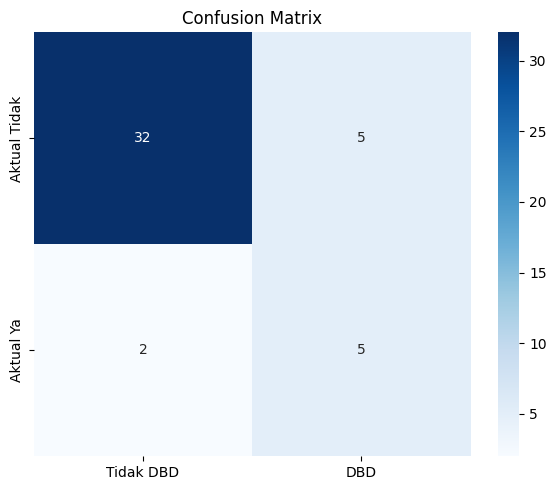

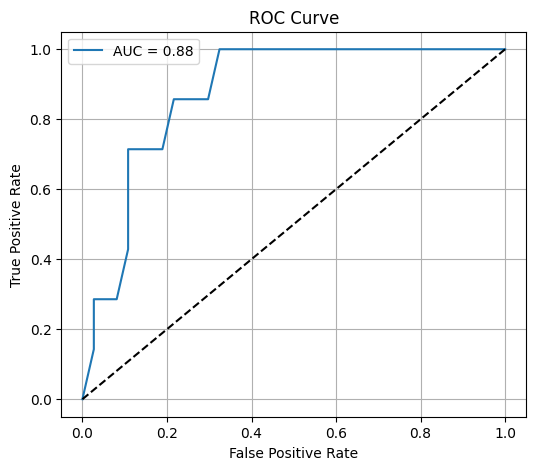

c:\Users\HUAWEI\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
2 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\HUAWEI\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\HUAWEI\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\HUAWEI\AppData\Local\Programs\Python\Python39\lib\site-packages\

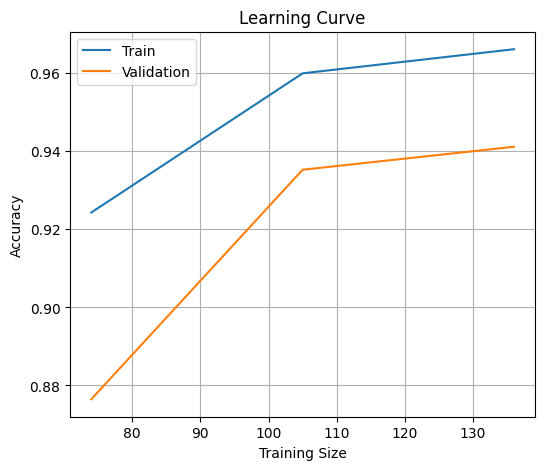


📊 Hasil Kategorisasi Kecamatan:
Purwokerto Barat → Rendah (7 prediksi kasus)
Purwokerto Selatan → Rendah (7 prediksi kasus)
Purwokerto Timur → Rendah (7 prediksi kasus)
Purwokerto Utara → Rendah (7 prediksi kasus)

✅ Proses selesai. File CSV, GeoJSON, HTML, dan model telah disimpan.


In [ ]:
# ============================================
# LIBRARY
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium

from shapely.geometry import Point
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE
from scipy.stats import uniform
import joblib

# ============================================
# 1. BACA DATA EXCEL
# ============================================
df = pd.read_excel('D:/KULIAH 2023/PENELITIAN/File/data_dbd_purwokerto_2022_2024.xlsx')

# ============================================
# 2. TAMBAHKAN KOORDINAT KECAMATAN
# ============================================
koordinat = {
    'Purwokerto Timur': (-7.424467, 109.244497),
    'Purwokerto Barat': (-7.423089, 109.217737),
    'Purwokerto Selatan': (-7.442619, 109.241523),
    'Purwokerto Utara': (-7.3989999, 109.2385498)
}

df['Kecamatan'] = df['Wilayah']
df['Latitude'] = df['Kecamatan'].map(lambda x: koordinat[x][0])
df['Longitude'] = df['Kecamatan'].map(lambda x: koordinat[x][1])

# ============================================
# 3. BINARY TARGET
# ============================================
df['Kasus DBD (0=Tidak, 1=Ya)'] = (df['Jumlah Kasus DBD'] > 5).astype(int)

# ============================================
# 4. PERSIAPAN FITUR & TARGET
# ============================================
fitur = ['Suhu (C)', 'Kelembaban (%)', 'Curah Hujan (mm)', 'Bulan']
X = df[fitur]
y = df['Kasus DBD (0=Tidak, 1=Ya)']

# ============================================
# 5. SPLIT DATA & SCALING
# ============================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ============================================
# 6. SMOTE
# ============================================
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# ============================================
# 7. TUNING DENGAN RANDOMIZED SEARCH
# ============================================
param_dist = {
    'C': uniform(0.1, 100),
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'poly', 'linear'],
    'degree': [2, 3, 4],
    'class_weight': ['balanced', None]
}

random_search = RandomizedSearchCV(SVC(probability=True), param_distributions=param_dist,
                                   n_iter=30, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train_resampled, y_train_resampled)
best_svm = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

# ============================================
# 8. EVALUASI
# ============================================
y_pred = best_svm.predict(X_test_scaled)
y_proba = best_svm.predict_proba(X_test_scaled)[:, 1]

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ============================================
# 9. VISUALISASI EVALUASI
# ============================================

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Tidak DBD', 'DBD'], yticklabels=['Aktual Tidak', 'Aktual Ya'])
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(best_svm, X_train_resampled, y_train_resampled, cv=5)
plt.figure(figsize=(6,5))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()

# ============================================
# 10. PREDIKSI & KATEGORISASI KECAMATAN
# ============================================
X_scaled_all = scaler.transform(X)
df['Prediksi DBD'] = best_svm.predict(X_scaled_all)

agg_df = df.groupby('Kecamatan').agg({
    'Prediksi DBD': 'sum',
    'Latitude': 'first',
    'Longitude': 'first'
}).reset_index()

quartiles = agg_df['Prediksi DBD'].quantile([0.25, 0.5, 0.75]).values
def kategori(x):
    if x <= quartiles[0]:
        return 'Rendah'
    elif x <= quartiles[1]:
        return 'Sedang'
    elif x <= quartiles[2]:
        return 'Tinggi'
    else:
        return 'Sangat Tinggi'

agg_df['Kategori'] = agg_df['Prediksi DBD'].apply(kategori)
warna = {'Rendah':'green', 'Sedang':'yellow', 'Tinggi':'orange', 'Sangat Tinggi':'red'}
agg_df['Warna'] = agg_df['Kategori'].map(warna)

# ============================================
# 11. SIMPAN FILE OUTPUT
# ============================================
geometry = [Point(xy) for xy in zip(agg_df['Longitude'], agg_df['Latitude'])]
gdf = gpd.GeoDataFrame(agg_df, geometry=geometry, crs="EPSG:4326")
agg_df.to_csv('prediksi_dbd_kecamatan.csv', index=False)
gdf.to_file('prediksi_dbd_kecamatan.geojson', driver='GeoJSON')
joblib.dump(best_svm, 'best_svm_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# ============================================
# 12. PETA INTERAKTIF FOLIUM
# ============================================
m = folium.Map(location=[-7.42, 109.23], zoom_start=12)
for _, row in agg_df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=10,
        popup=f"{row['Kecamatan']}: {row['Kategori']}",
        color=row['Warna'],
        fill=True,
        fill_color=row['Warna']
    ).add_to(m)

m.save('peta_prediksi_dbd.html')

# ============================================
# 13. OUTPUT KE TERMINAL
# ============================================
print("\n📊 Hasil Kategorisasi Kecamatan:")
for _, row in agg_df.iterrows():
    print(f"{row['Kecamatan']} → {row['Kategori']} ({row['Prediksi DBD']} prediksi kasus)")

print("\n✅ Proses selesai. File CSV, GeoJSON, HTML, dan model telah disimpan.")

# proses dalam pengalaman kali ini adalah memberi tahukan kepada seluruh orang bahwa gak semua liburan itu enak ada sebuah perasaan yang tidak b
# bisa diungkapkan karena memang dalam penyampaiannya kurang memberikan
# bagaimana memasuki lingkungan dengan gaya hidup mkota besar
# value apa yang harus aku punya untuk memasuki lingkungan itu
# jenis kehidupan/gaya hidup apa yang harus aku pelajari dilingkungan kota besar
# keseharian seperti apa yang harus aku lakukan untuk mendapatkan semua kesuksesan itu

# setelah aku menjalani kehidupan di kota besar tepatnya ibukota Jakarta , aku emndapat banyak hal yang membuat aku merasa terbelakan mulai dari
# insecure karena warna kulit, ras dll, aku juga sempat berpikir bagaimana bisa mereka hidupdalam kemewahan itu, ternyata memang lingkungan sangatlah
# berpengaruh terhadap gaya hidup di kota besar, kota kecil, ataupun pedesaan. Namun satu hal yang pasti yang bisa aku dapatkan disini yaitu
# kita harus punya pekerjaan tetap terlebih dahulu, karena itu akan menunjang 
